<h1 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Alzheimer MR Images Classification</h1>

<div style="color: black; background-color: lightsteelblue; border:2px solid black;">
    <ul>
        <p>6400 different MRIs (Magnetic Resonance Image) collected from different sources were given in this project. 6400 images belong to 4 different classes. These classes are as follows;</p>
            <li>Mild Demented</li>
            <li>Moderate Demented</li>
            <li>Non Demented</li>
            <li>Very Mild Demented</li>
            <br>
        <p>After examining the target value distribution, we will split the data into training, testing, and validation datasets. Next, we will create a model using Convolutional Neural Networks (CNN). After the model is trained, we will evaluate its performance by assessing how accurately it predicts previously unseen Magnetic Resonance Images.</p>
    </ul>
</div>

# Importing Necessary Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]

In [20]:
try:
    if tf.test.gpu_device_name():
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print('GPU active! -', physical_devices)
    else:
        print('GPU not active!')
except Exception as e:
    print('An error occurred while checking the GPU:', e)

GPU not active!


# Target Value Distribution

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">Seeing the distribution of the target values is of critical importance in determining the methods to be applied in the subsequent steps. Therefore, let's first navigate to the data folder path and check the number of images in each class folder.</p>

A search has been initiated within the folder named 'dementia'.
There are 64 images in the ModerateDemented folder.
There are 3200 images in the NonDemented folder.
There are 2240 images in the VeryMildDemented folder.
There are 896 images in the MildDemented folder.
The search has been completed.


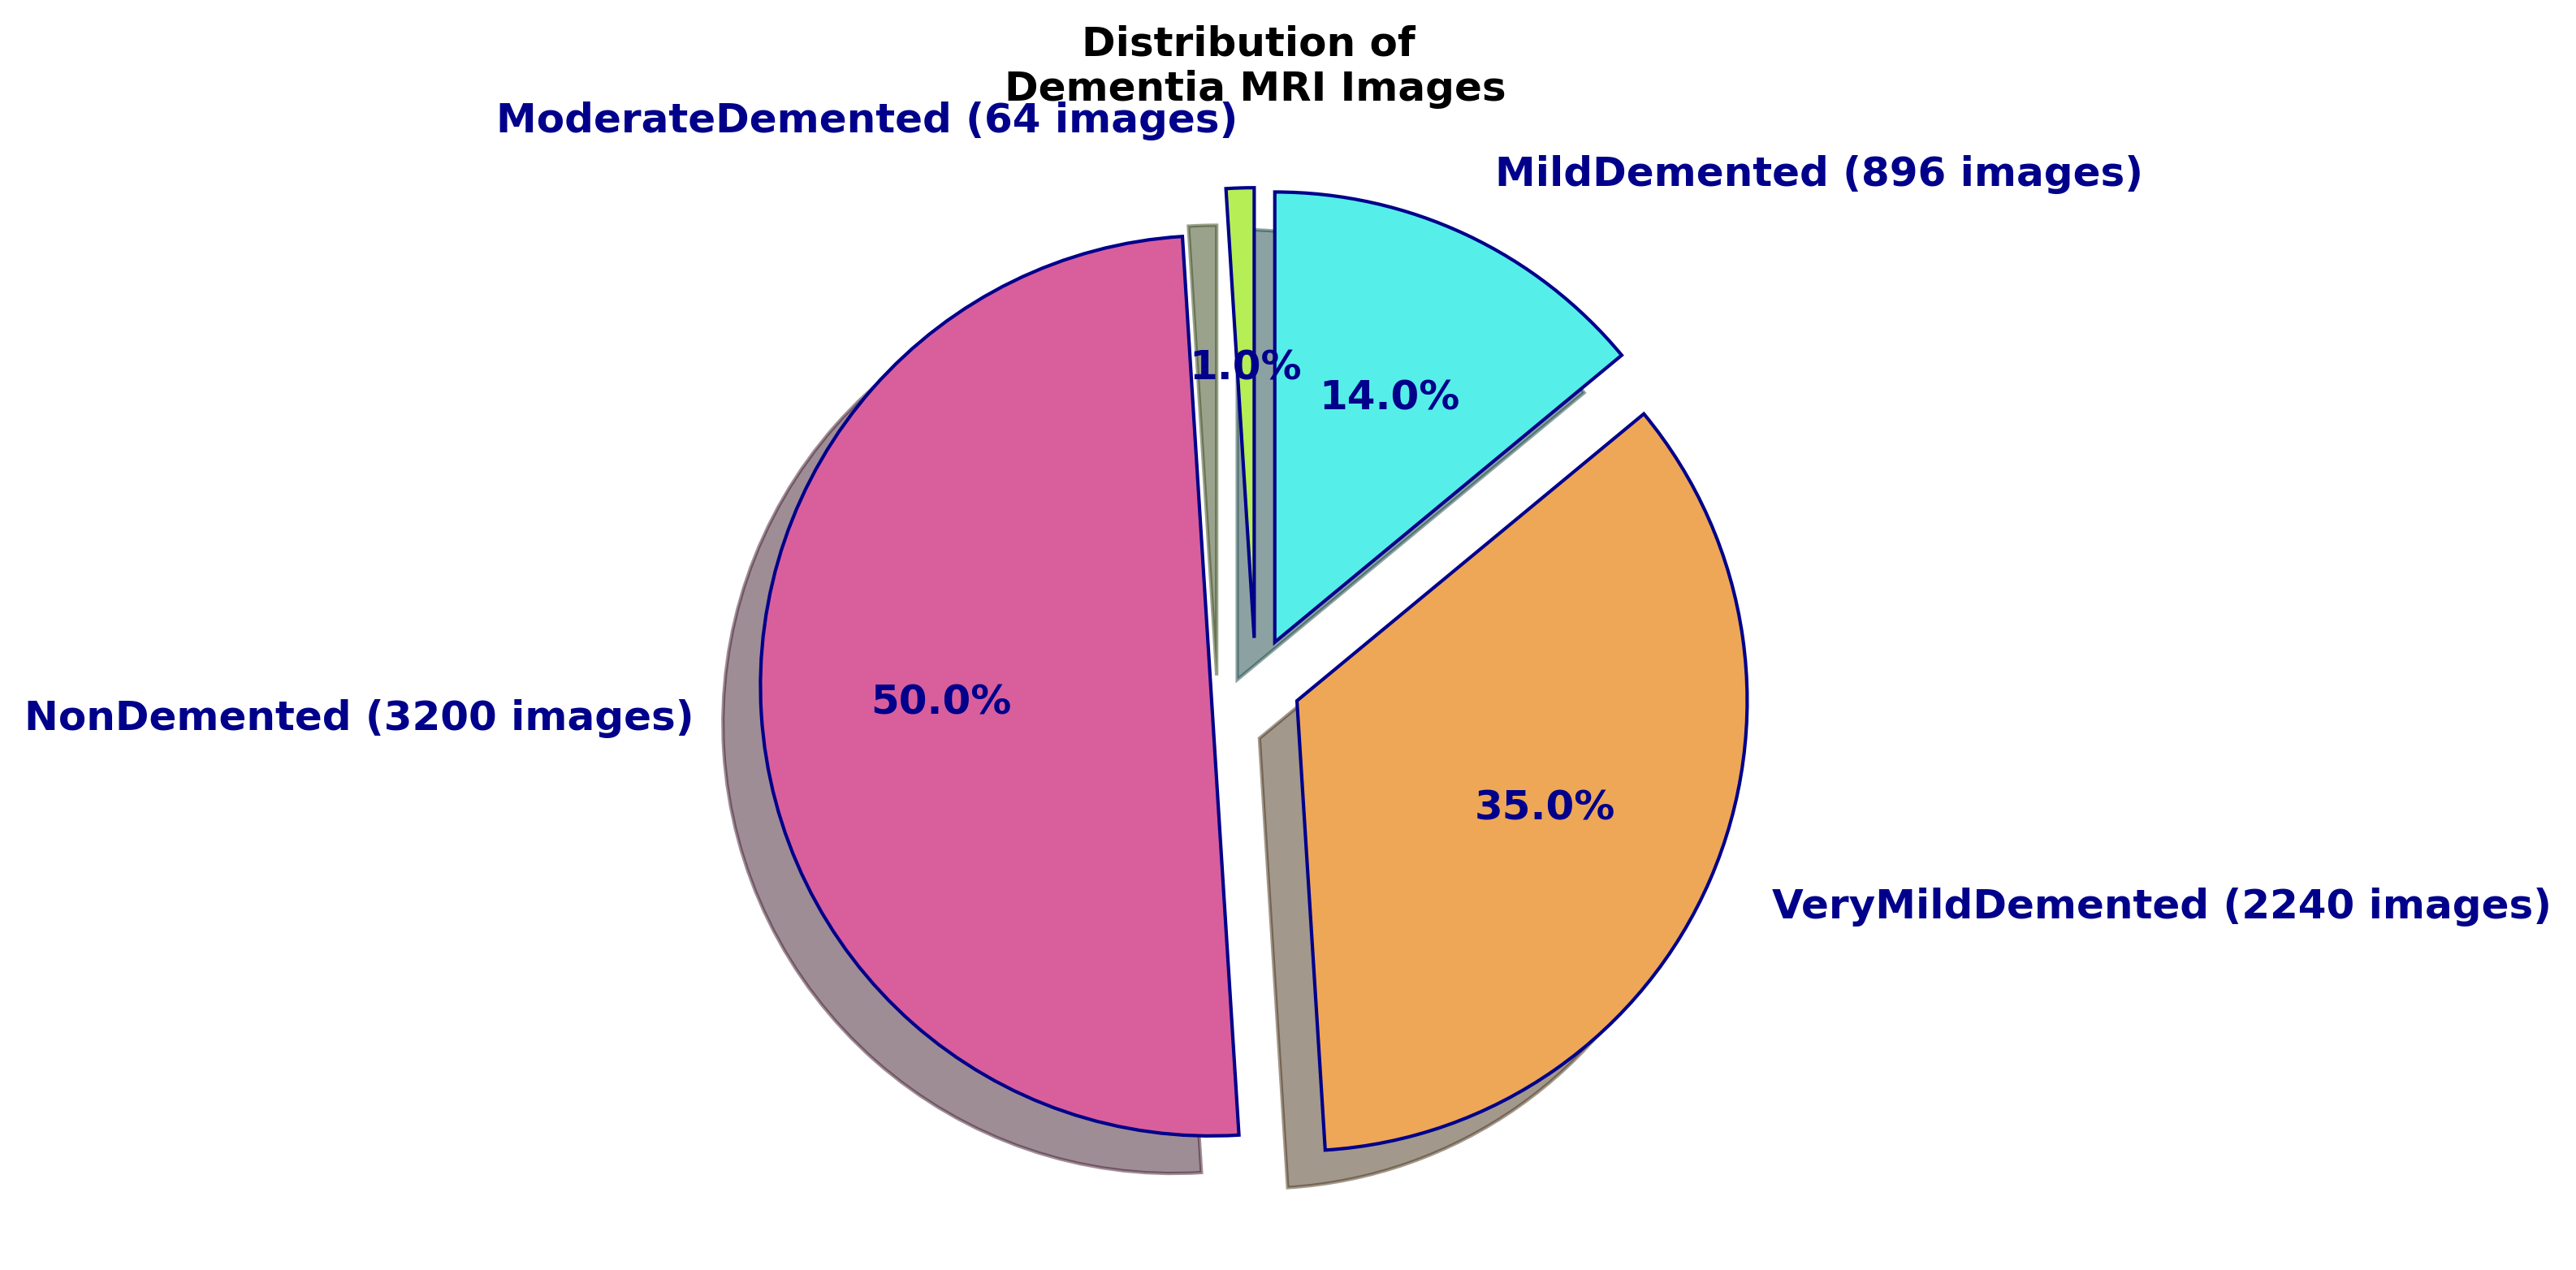

In [21]:
class_dist = {}
def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"A search has been initiated within the folder named '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1
            
            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m'+"The search has been completed."+'\033[0m')
    
    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)
    
    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]
    
    plt.pie(values, explode=explode,labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors, textprops={'fontsize': 12, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
           {'edgecolor':'darkblue'} , labeldistance=1.15)
    plt.title("Distribution of \nDementia MRI Images", size=12, fontweight="bold")

PATH = '/kaggle/input/dementia'

image_counter(PATH)

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">As observed in the class distribution, we have an imbalanced dataset. <b>Non Demented MRI class constitutes 50% of the total data with 3200 images</b>, while <b>Moderate Demented MRI class only makes up 1% of the dataset with 64 images.</b></p>

# Generate TF Dataset

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">When examining the data path, we can see that the folder named <b>"Dataset"</b> is the main folder, and within it, there are separate folders for each class containing their respective images.</p>

<div style="color: black; background-color: lightsteelblue; border:2px solid black;">
<b>Dataset/</b>
<br><b>...Mild_Demented/</b>
<br>......mild_1.jpg
<br>......mild_2.jpg
<br><b>...Moderate_Demented/</b>
<br>......moderate_1.jpg
<br>......moderate_2.jpg
<br>
<br>
<p>When encountering a situation with such a structure, TensorFlow has a powerful function <code>tf.keras.utils.image_dataset_from_directory</code> for reading data.</p>
    
</div>

In [22]:
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names

Found 6400 files belonging to 4 classes.


<p style="color: black; background-color: lightsteelblue; border:2px solid black;">Let's see some samples for each class!</p>

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">MRI Samples for Each Class</h2>

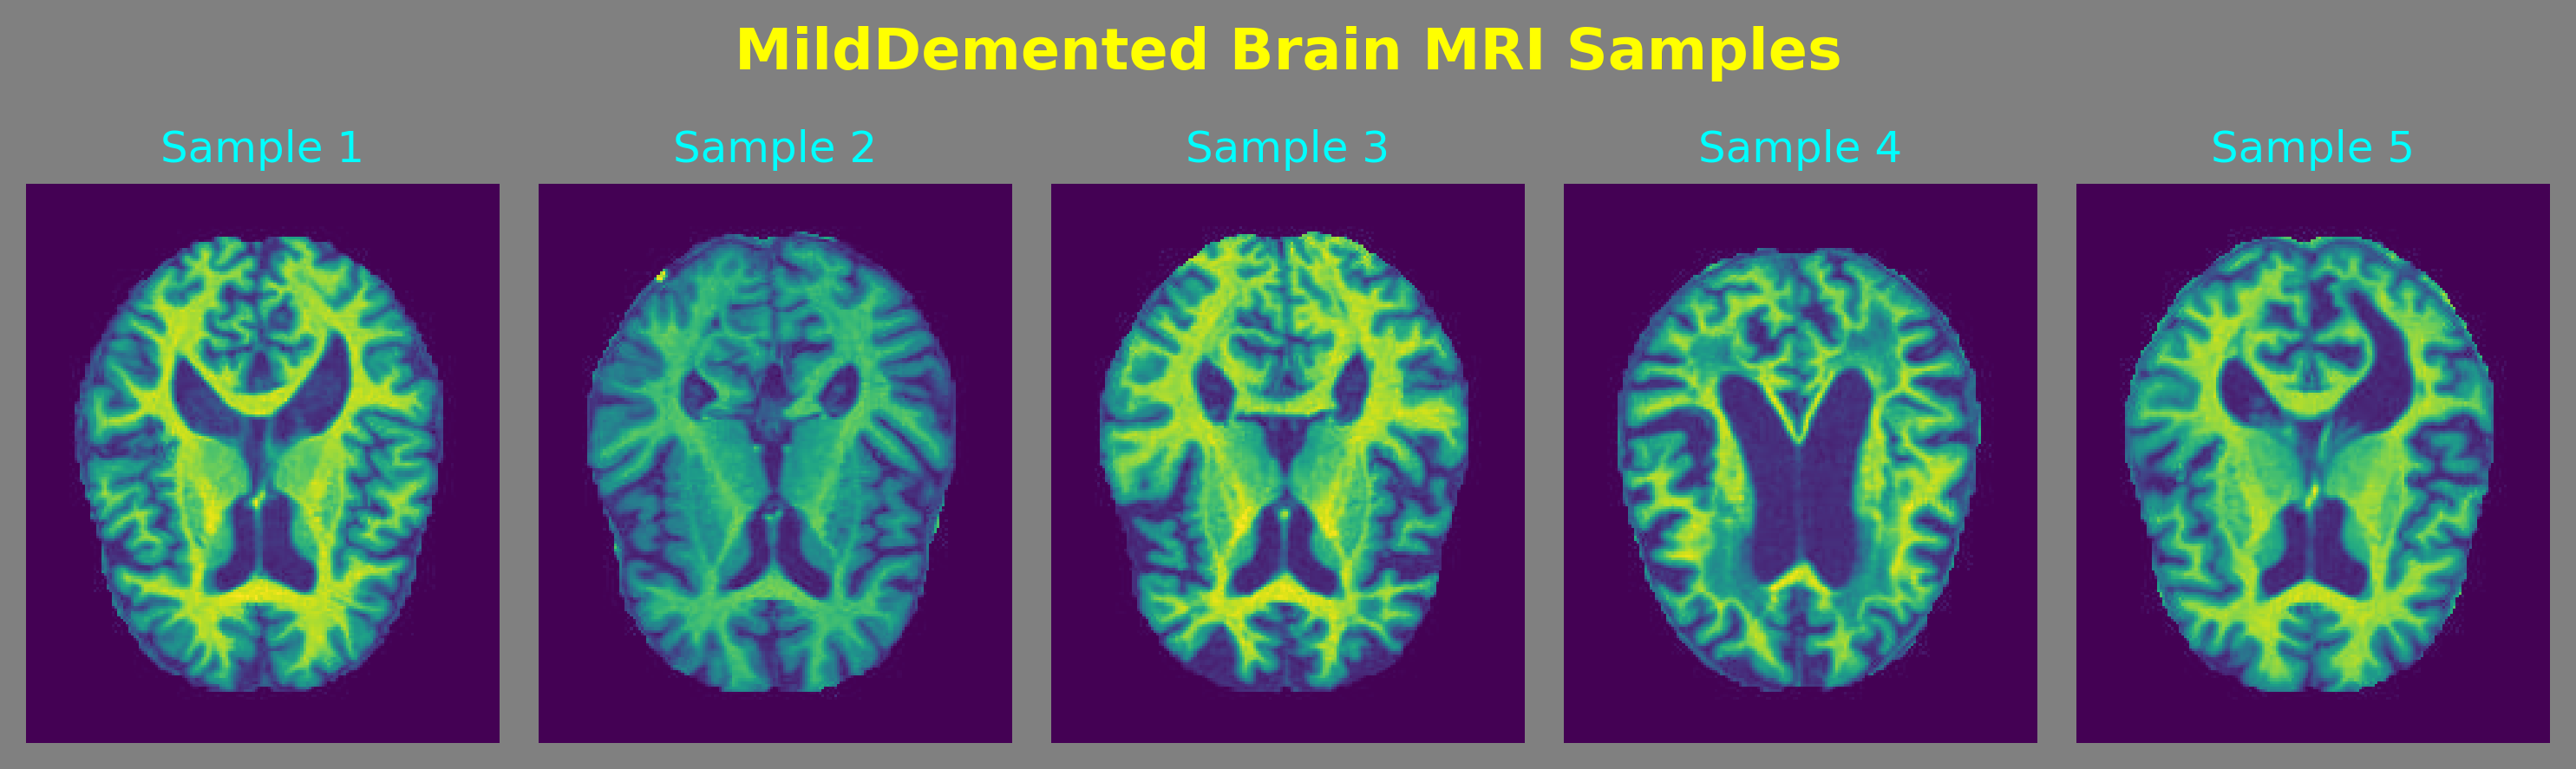

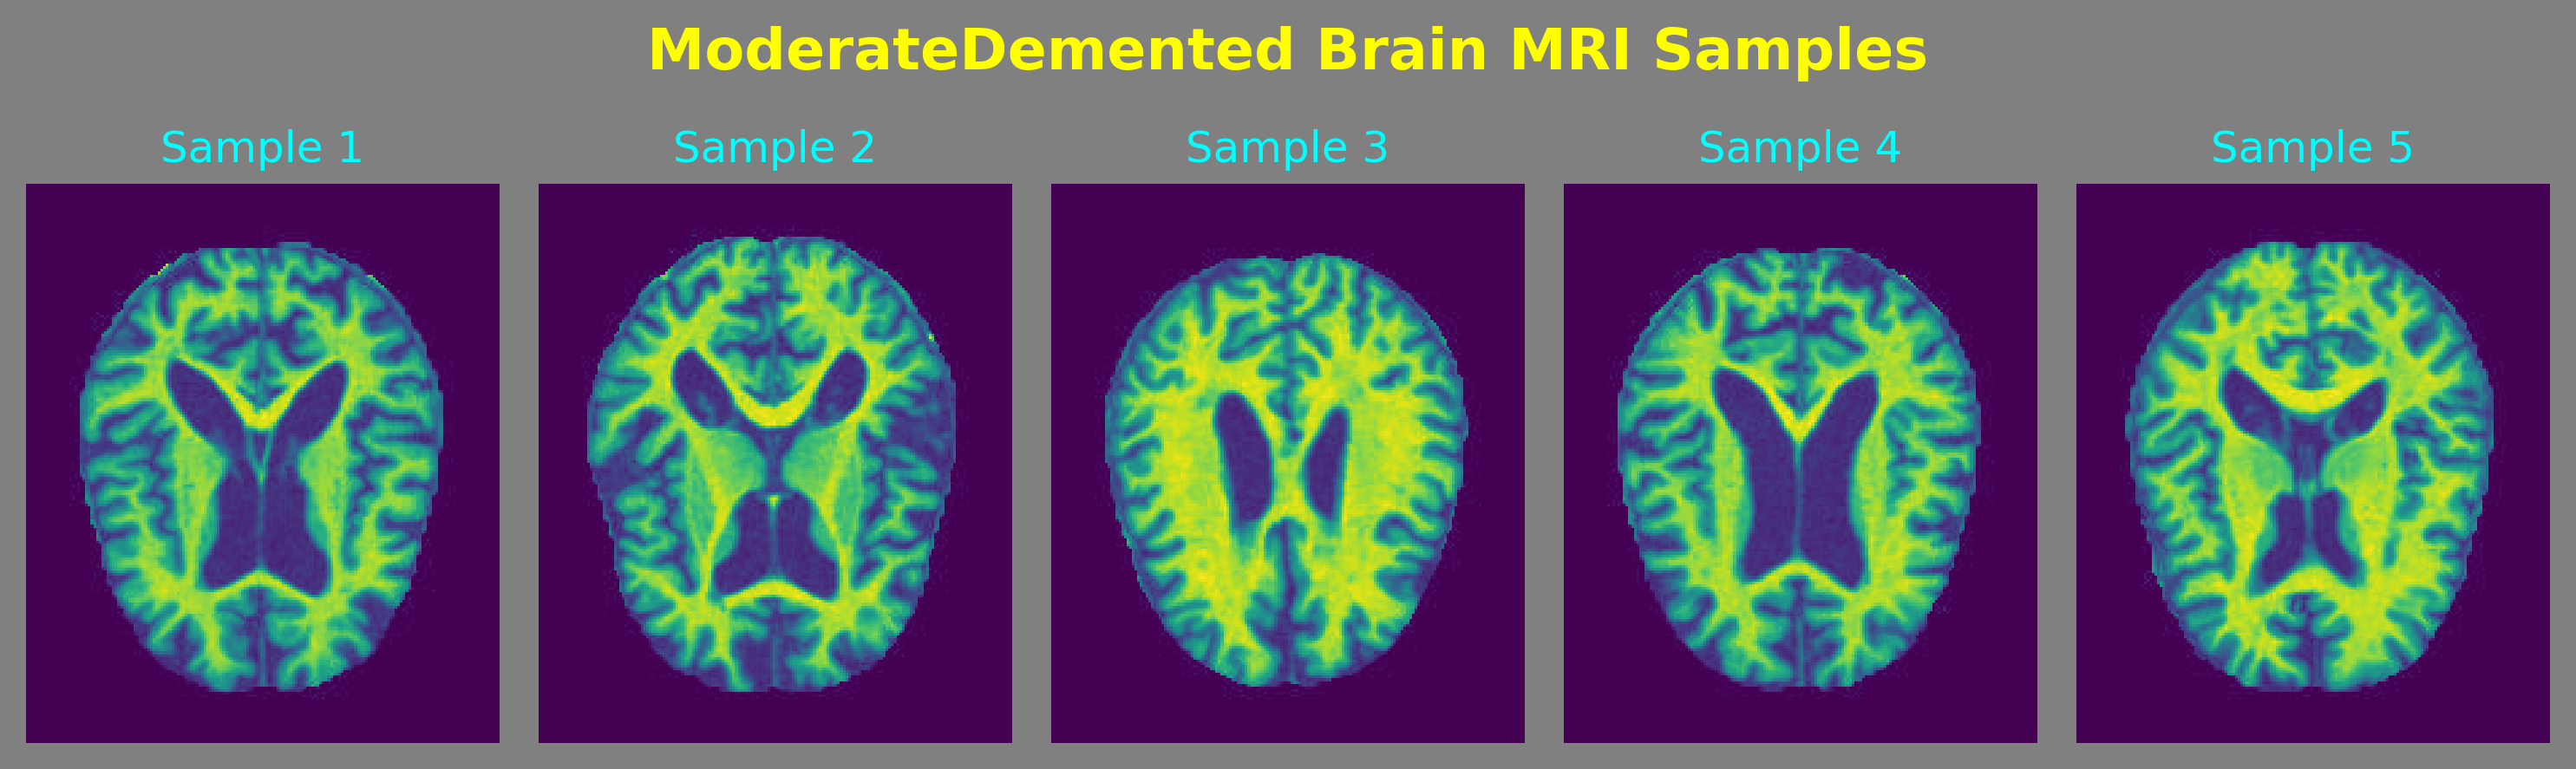

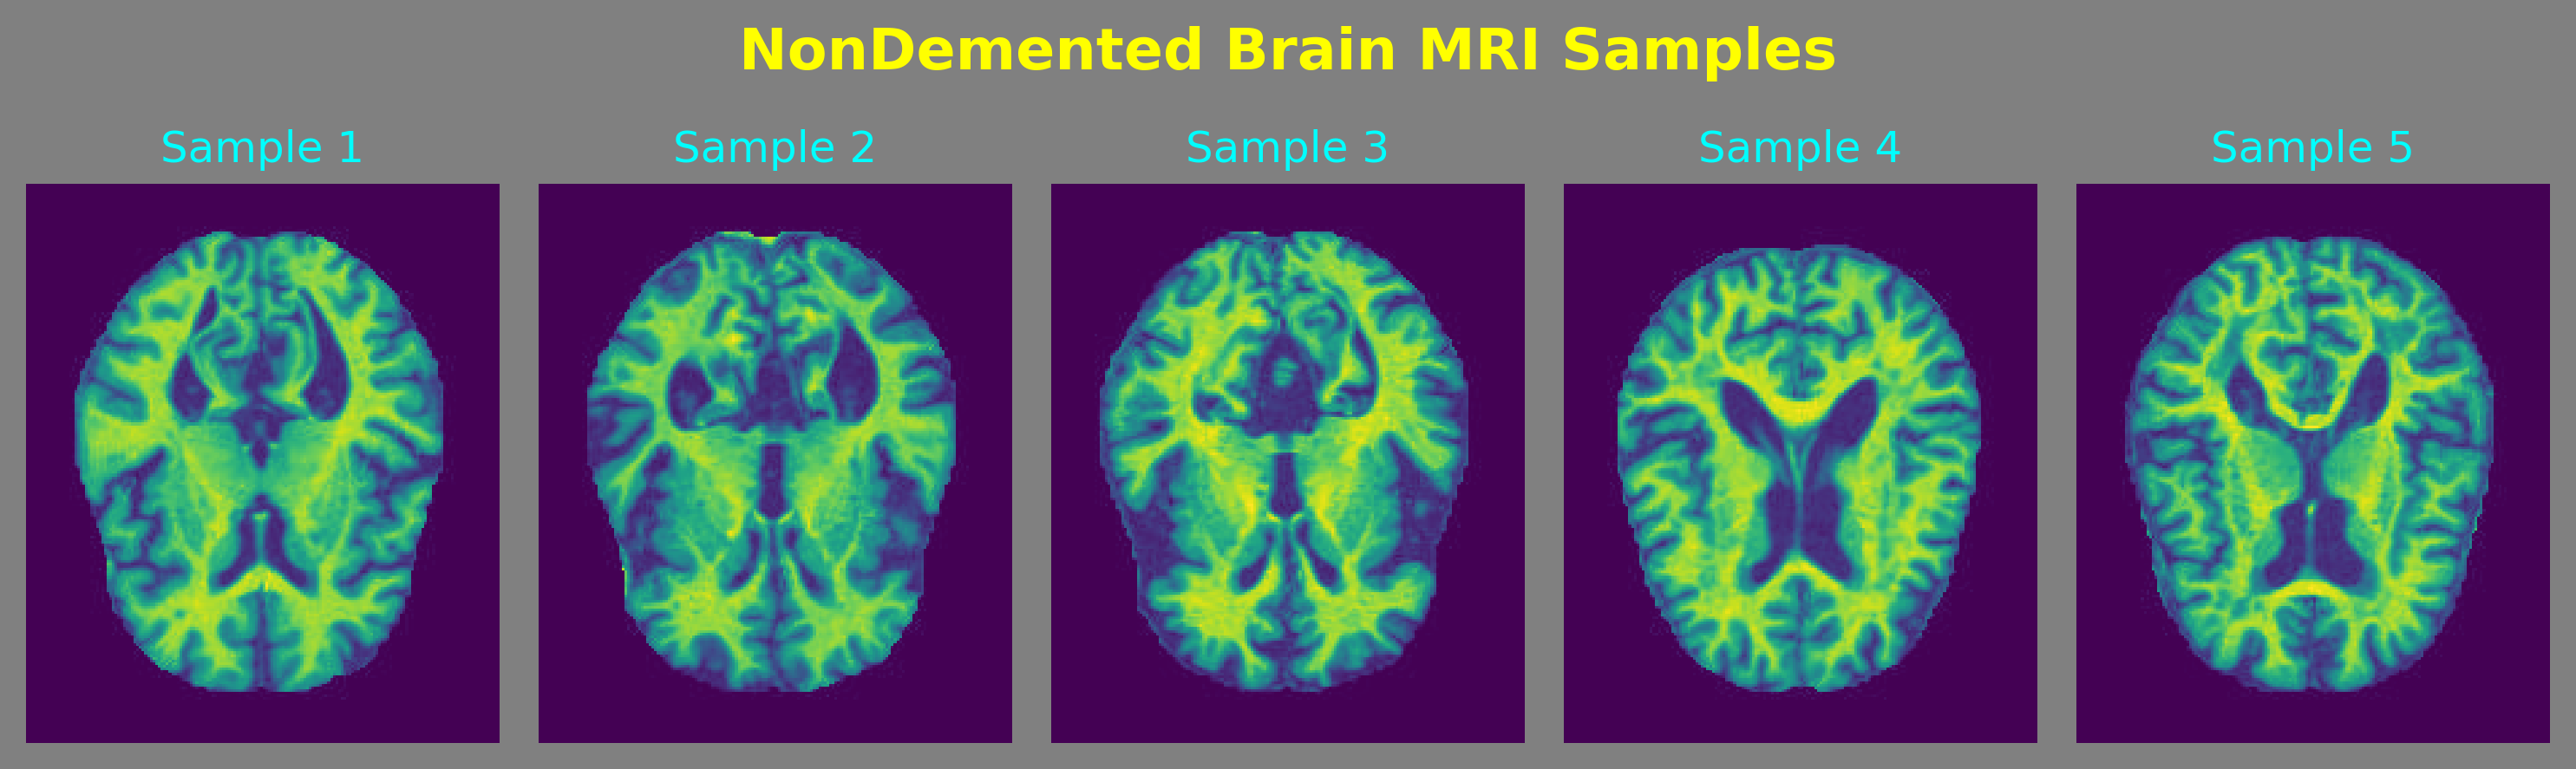

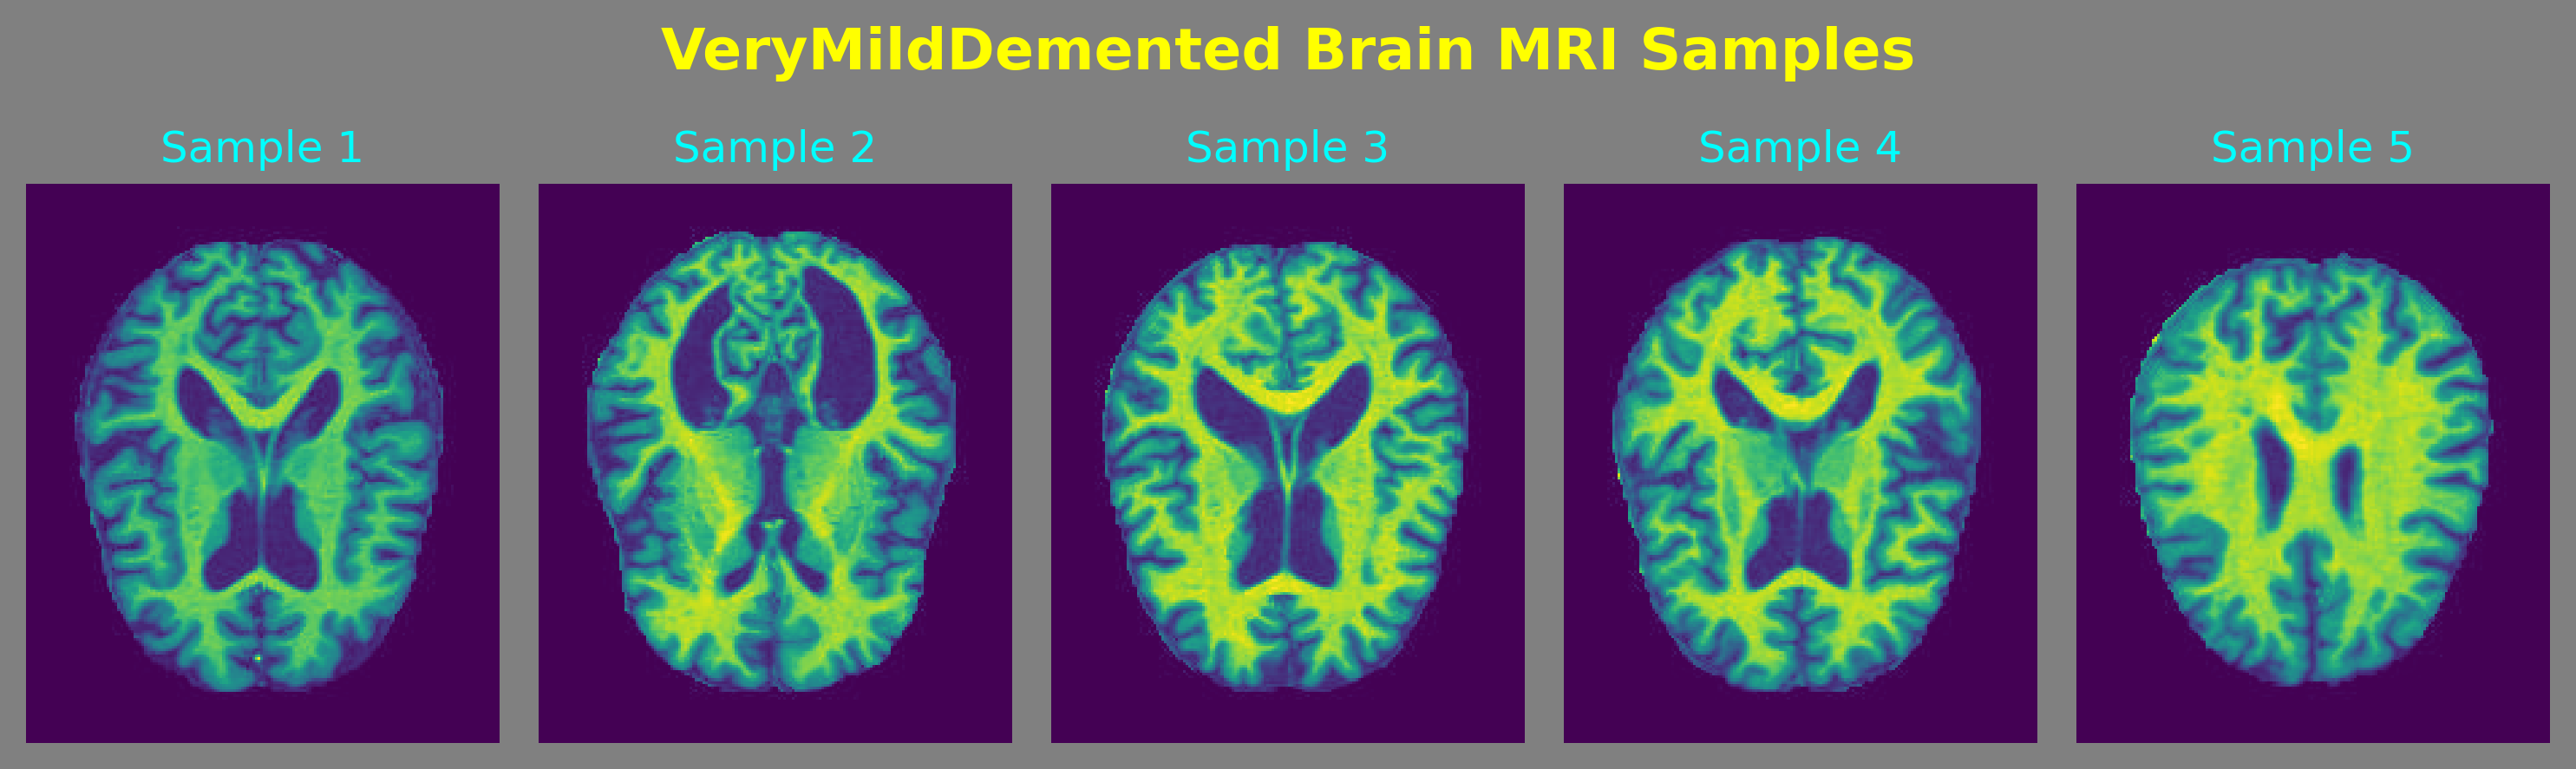

In [23]:
def sample_bringer(path, target, num_samples=5):
    
    class_path = os.path.join(path, target)

    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, facecolor="gray")
    fig.suptitle(f'{target} Brain MRI Samples', color="yellow",fontsize=16, fontweight='bold', y=0.75)
    
    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}', color="aqua")

    plt.tight_layout()
    
for target in class_names:
    sample_bringer(PATH, target=target)

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">Pixel normalization improves the performance of a neural network. Therefore, we will go with pixel values from 0 to 1, rather than values in the range 0 to 255.</p>

In [24]:
alz_dict = {index: img for index, img in enumerate(data.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())
        
    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="gray")
        fig.suptitle("Brain MRI (Dementia) Samples in the Batch", color="yellow",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="aqua")
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])
    
    def train_test_val_split(self, train_size, val_size, test_size):

        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)
        
        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data

Min and max pixel values in the batch -> 0.0 & 0.9939185


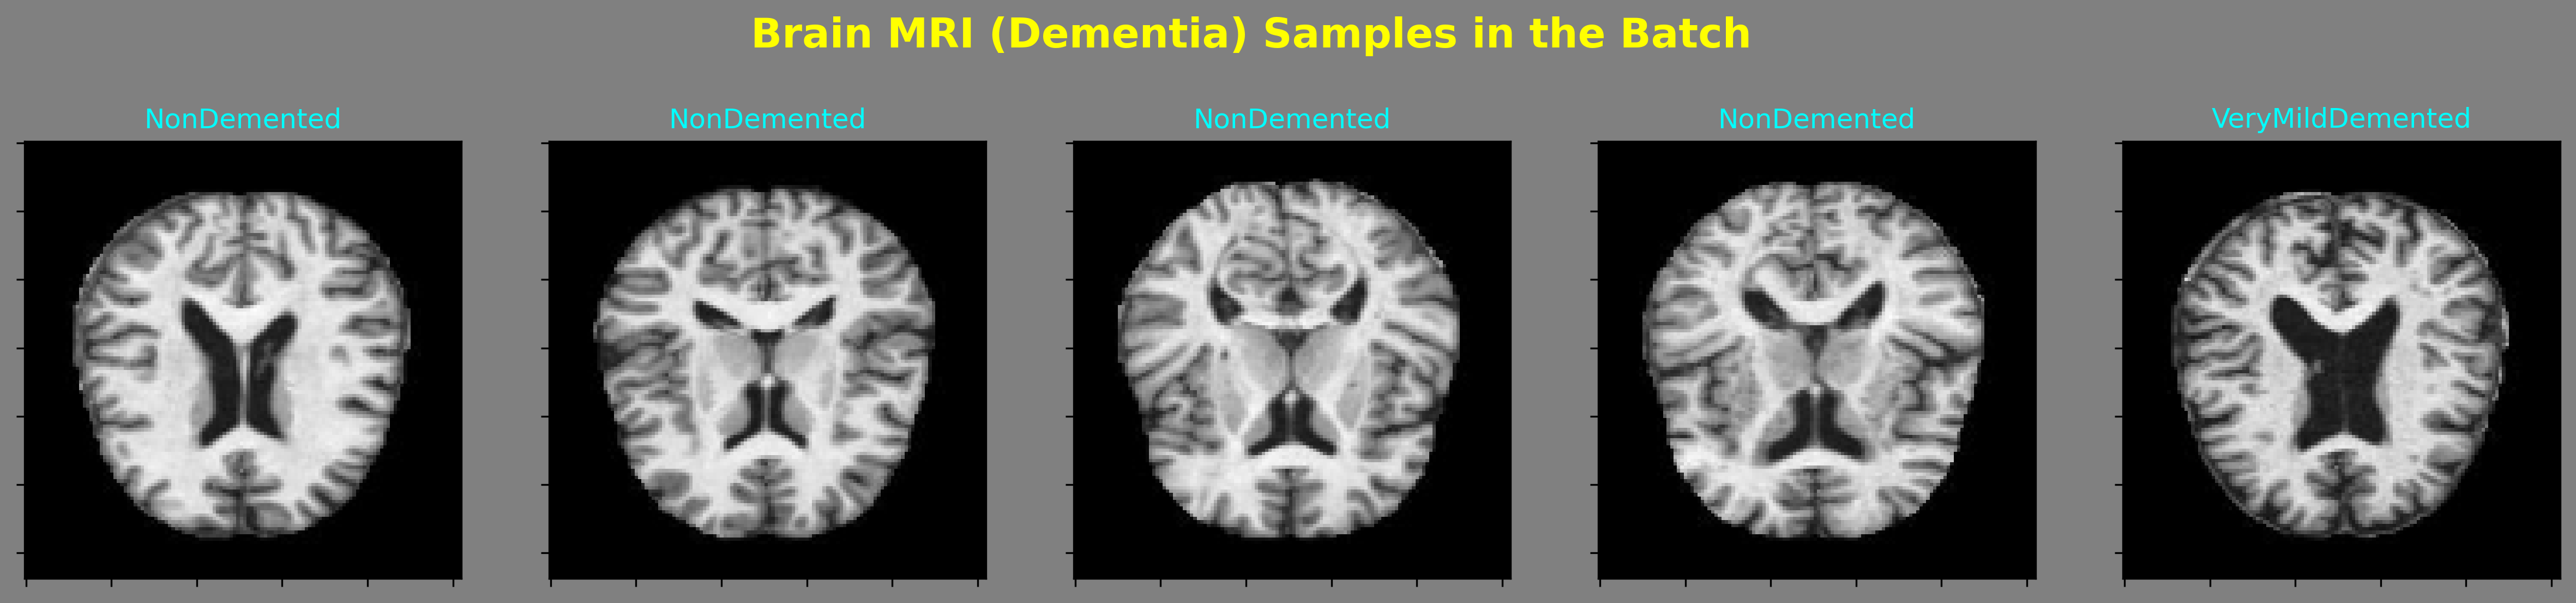

In [25]:
process = Process(data)
process.create_new_batch()
process.show_batch_images(number_of_images=5)

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">We will divide the dataset into 80% training data, 10% validation data and 10% test data.</p>

In [26]:
train_data, val_data, test_data= process.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">
We have an imbalanced distribution of target class. When dealing with an imbalanced target class distribution, using class weights can help the model perform better and effectively recognize the minority classes. Therefore, let's calculate the weights of the target classes in our training data and provide this information to our model during training.</p>

In [27]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

# Model Building

In [28]:
def build_model():
    model = Sequential()
    
    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    
    model.summary()
    
    return model

model = build_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)     

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Callbacks</h2>

In [29]:
def checkpoint_callback():
    
    checkpoint_filepath = '/tmp/checkpoint'
    
    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    
    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 10
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [30]:
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights, callbacks = callbacks)

Epoch 1/10
160/160 [==============================] - ETA: 0s - loss: 1.8270 - accuracy: 0.2031
Epoch 1: val_accuracy improved from -inf to 0.02969, saving model to /tmp/checkpoint
160/160 [==============================] - 56s 341ms/step - loss: 1.8270 - accuracy: 0.2031 - val_loss: 1.3905 - val_accuracy: 0.0297
Epoch 2/10
160/160 [==============================] - ETA: 0s - loss: 1.3773 - accuracy: 0.3545
Epoch 2: val_accuracy improved from 0.02969 to 0.19375, saving model to /tmp/checkpoint
160/160 [==============================] - 54s 339ms/step - loss: 1.3773 - accuracy: 0.3545 - val_loss: 1.6071 - val_accuracy: 0.1937
Epoch 3/10
160/160 [==============================] - ETA: 0s - loss: 1.2409 - accuracy: 0.4563
Epoch 3: val_accuracy improved from 0.19375 to 0.39062, saving model to /tmp/checkpoint
160/160 [==============================] - 57s 355ms/step - loss: 1.2409 - accuracy: 0.4563 - val_loss: 1.2443 - val_accuracy: 0.3906
Epoch 4/10
160/160 [=============================

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Loss and Accuracy</h2>

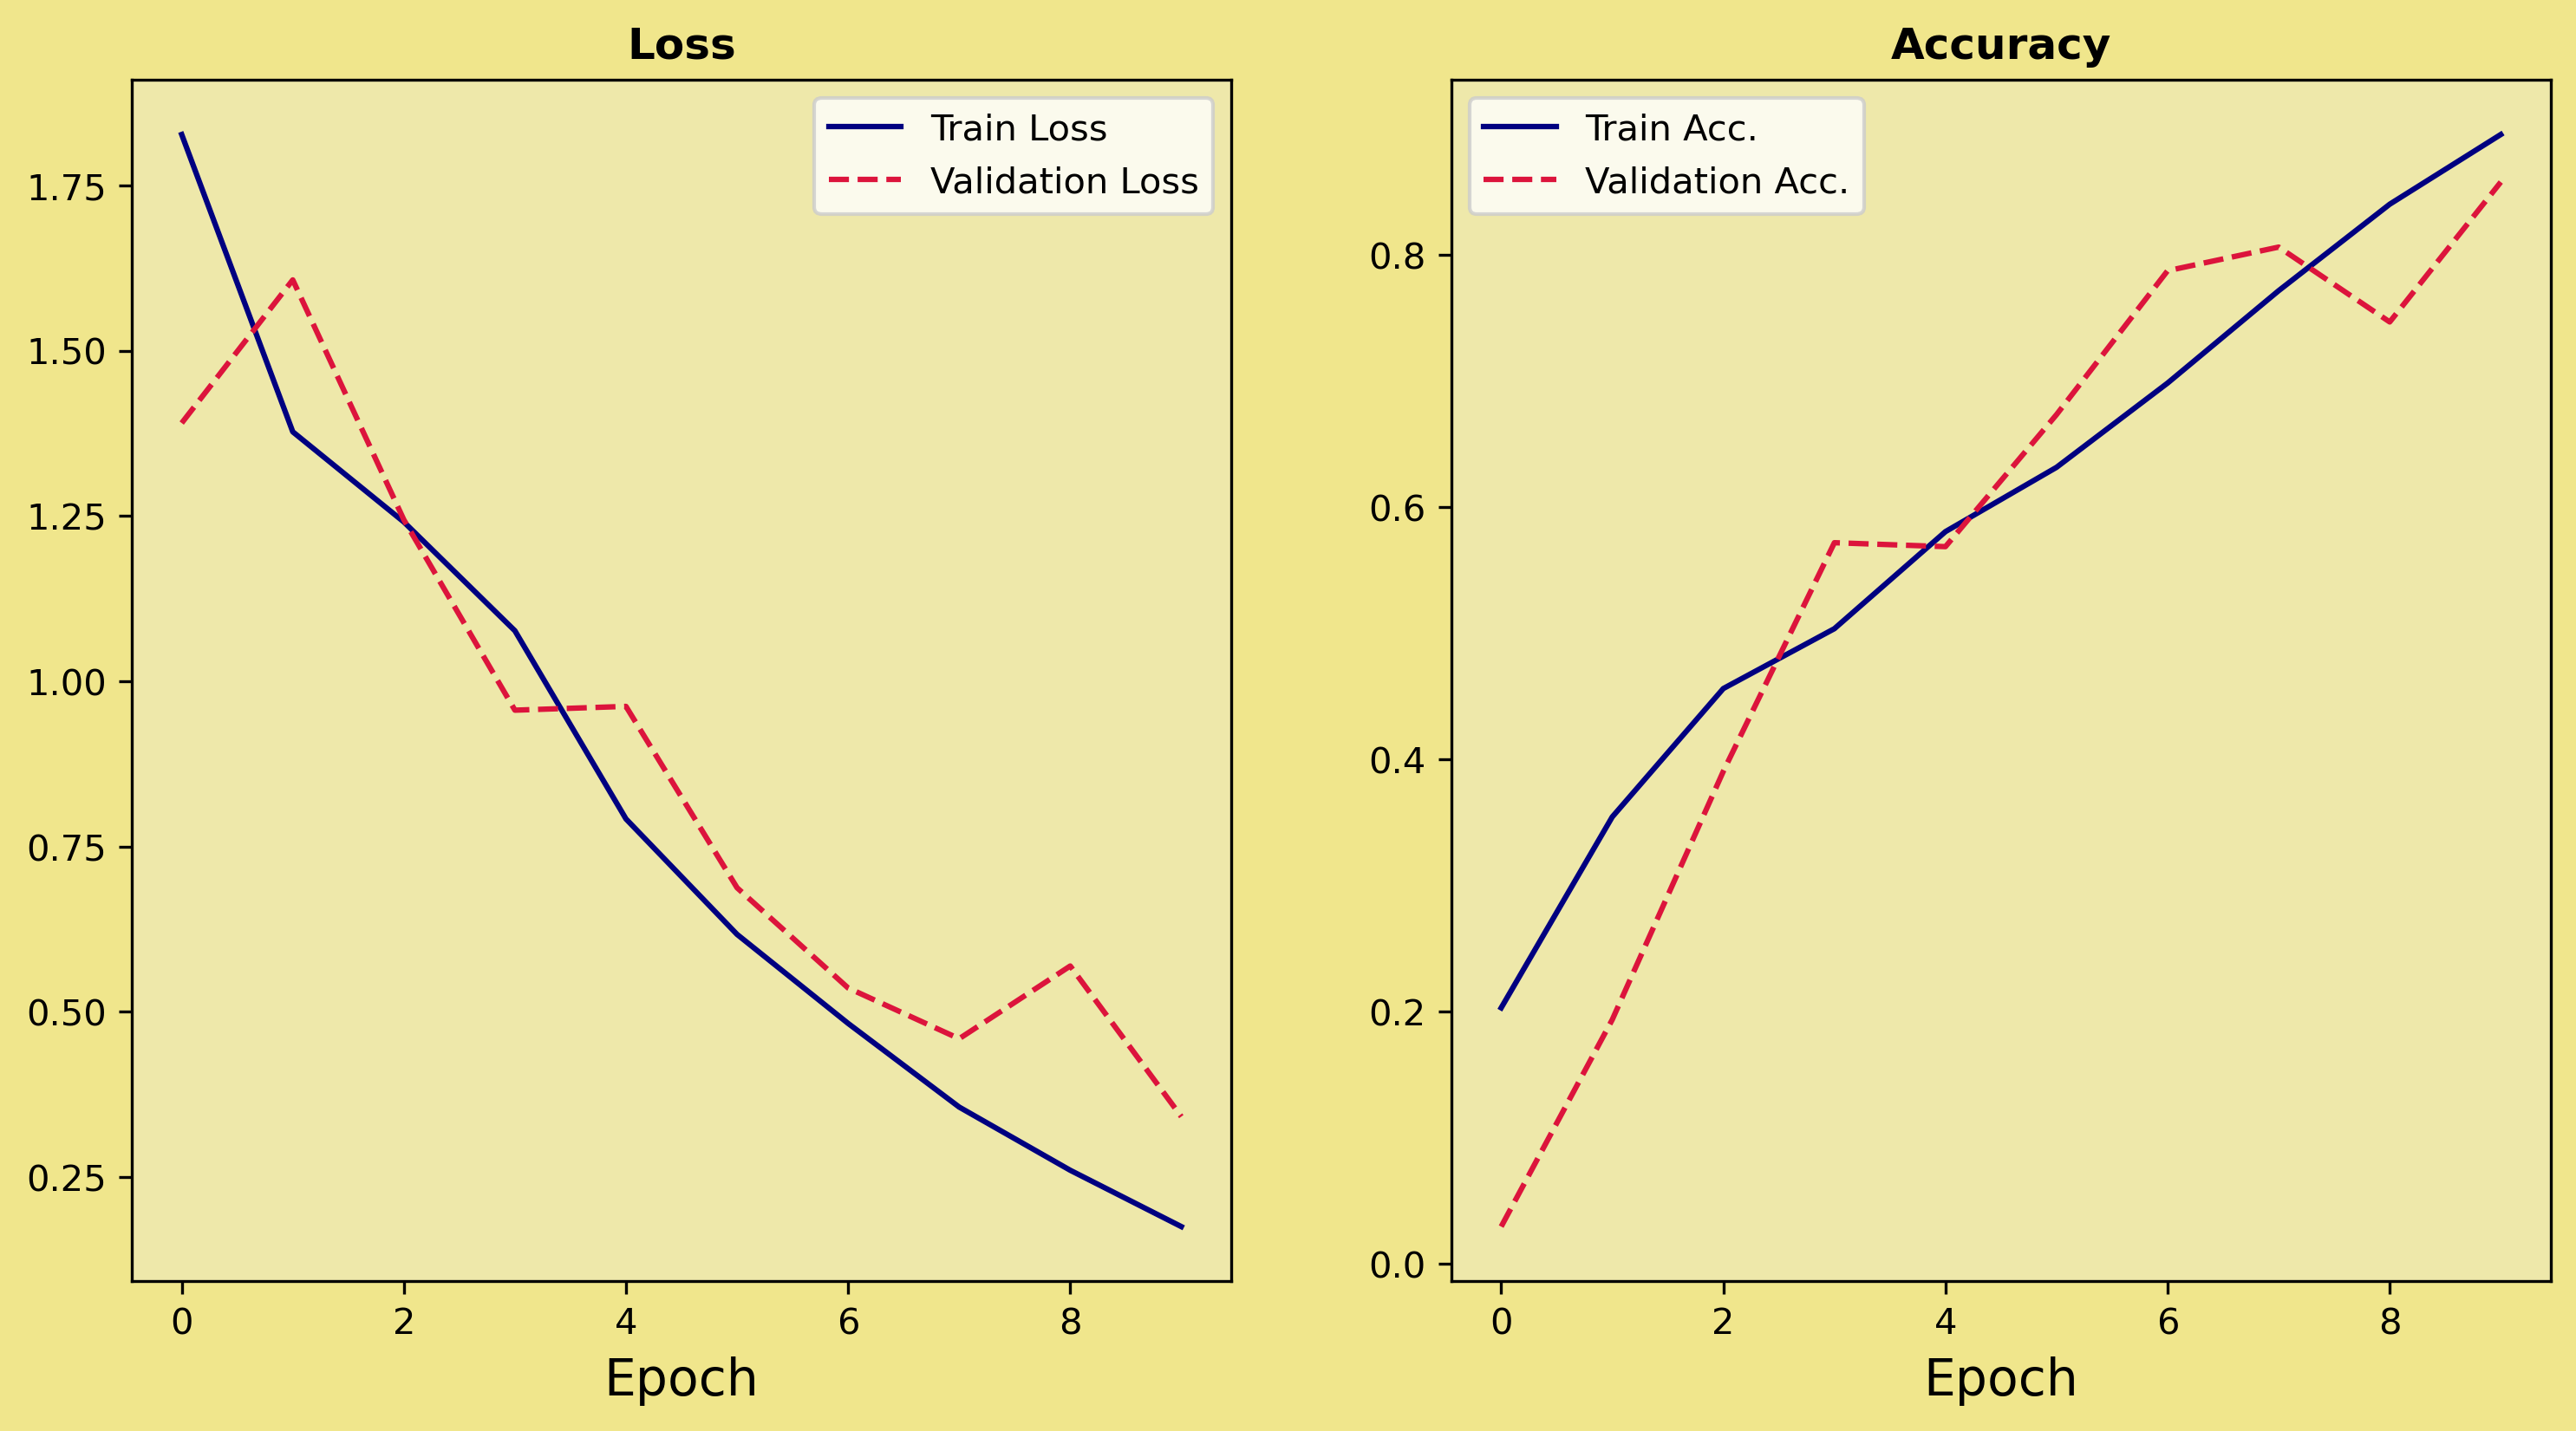

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="khaki")
ax[0].set_facecolor('palegoldenrod')  
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="navy")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="crimson", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('palegoldenrod')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="crimson", linestyle="dashed")
ax[1].legend()

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Evaluating Test Data</h2>

In [32]:
model.evaluate(test_data)

20/20 [==============================] - 4s 81ms/step - loss: 0.4597 - accuracy: 0.8047


[0.45965614914894104, 0.8046875]

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Classification Report</h2>

In [33]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)
    
predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                  precision    recall  f1-score   support

    MildDemented       0.57      0.99      0.72        77
ModerateDemented       1.00      1.00      1.00         5
     NonDemented       0.84      0.92      0.88       311
VeryMildDemented       0.94      0.61      0.74       247

        accuracy                           0.81       640
       macro avg       0.84      0.88      0.83       640
    weighted avg       0.85      0.81      0.81       640



<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Confusion Matrix</h2>

Text(289.1666666666666, 0.5, 'True')

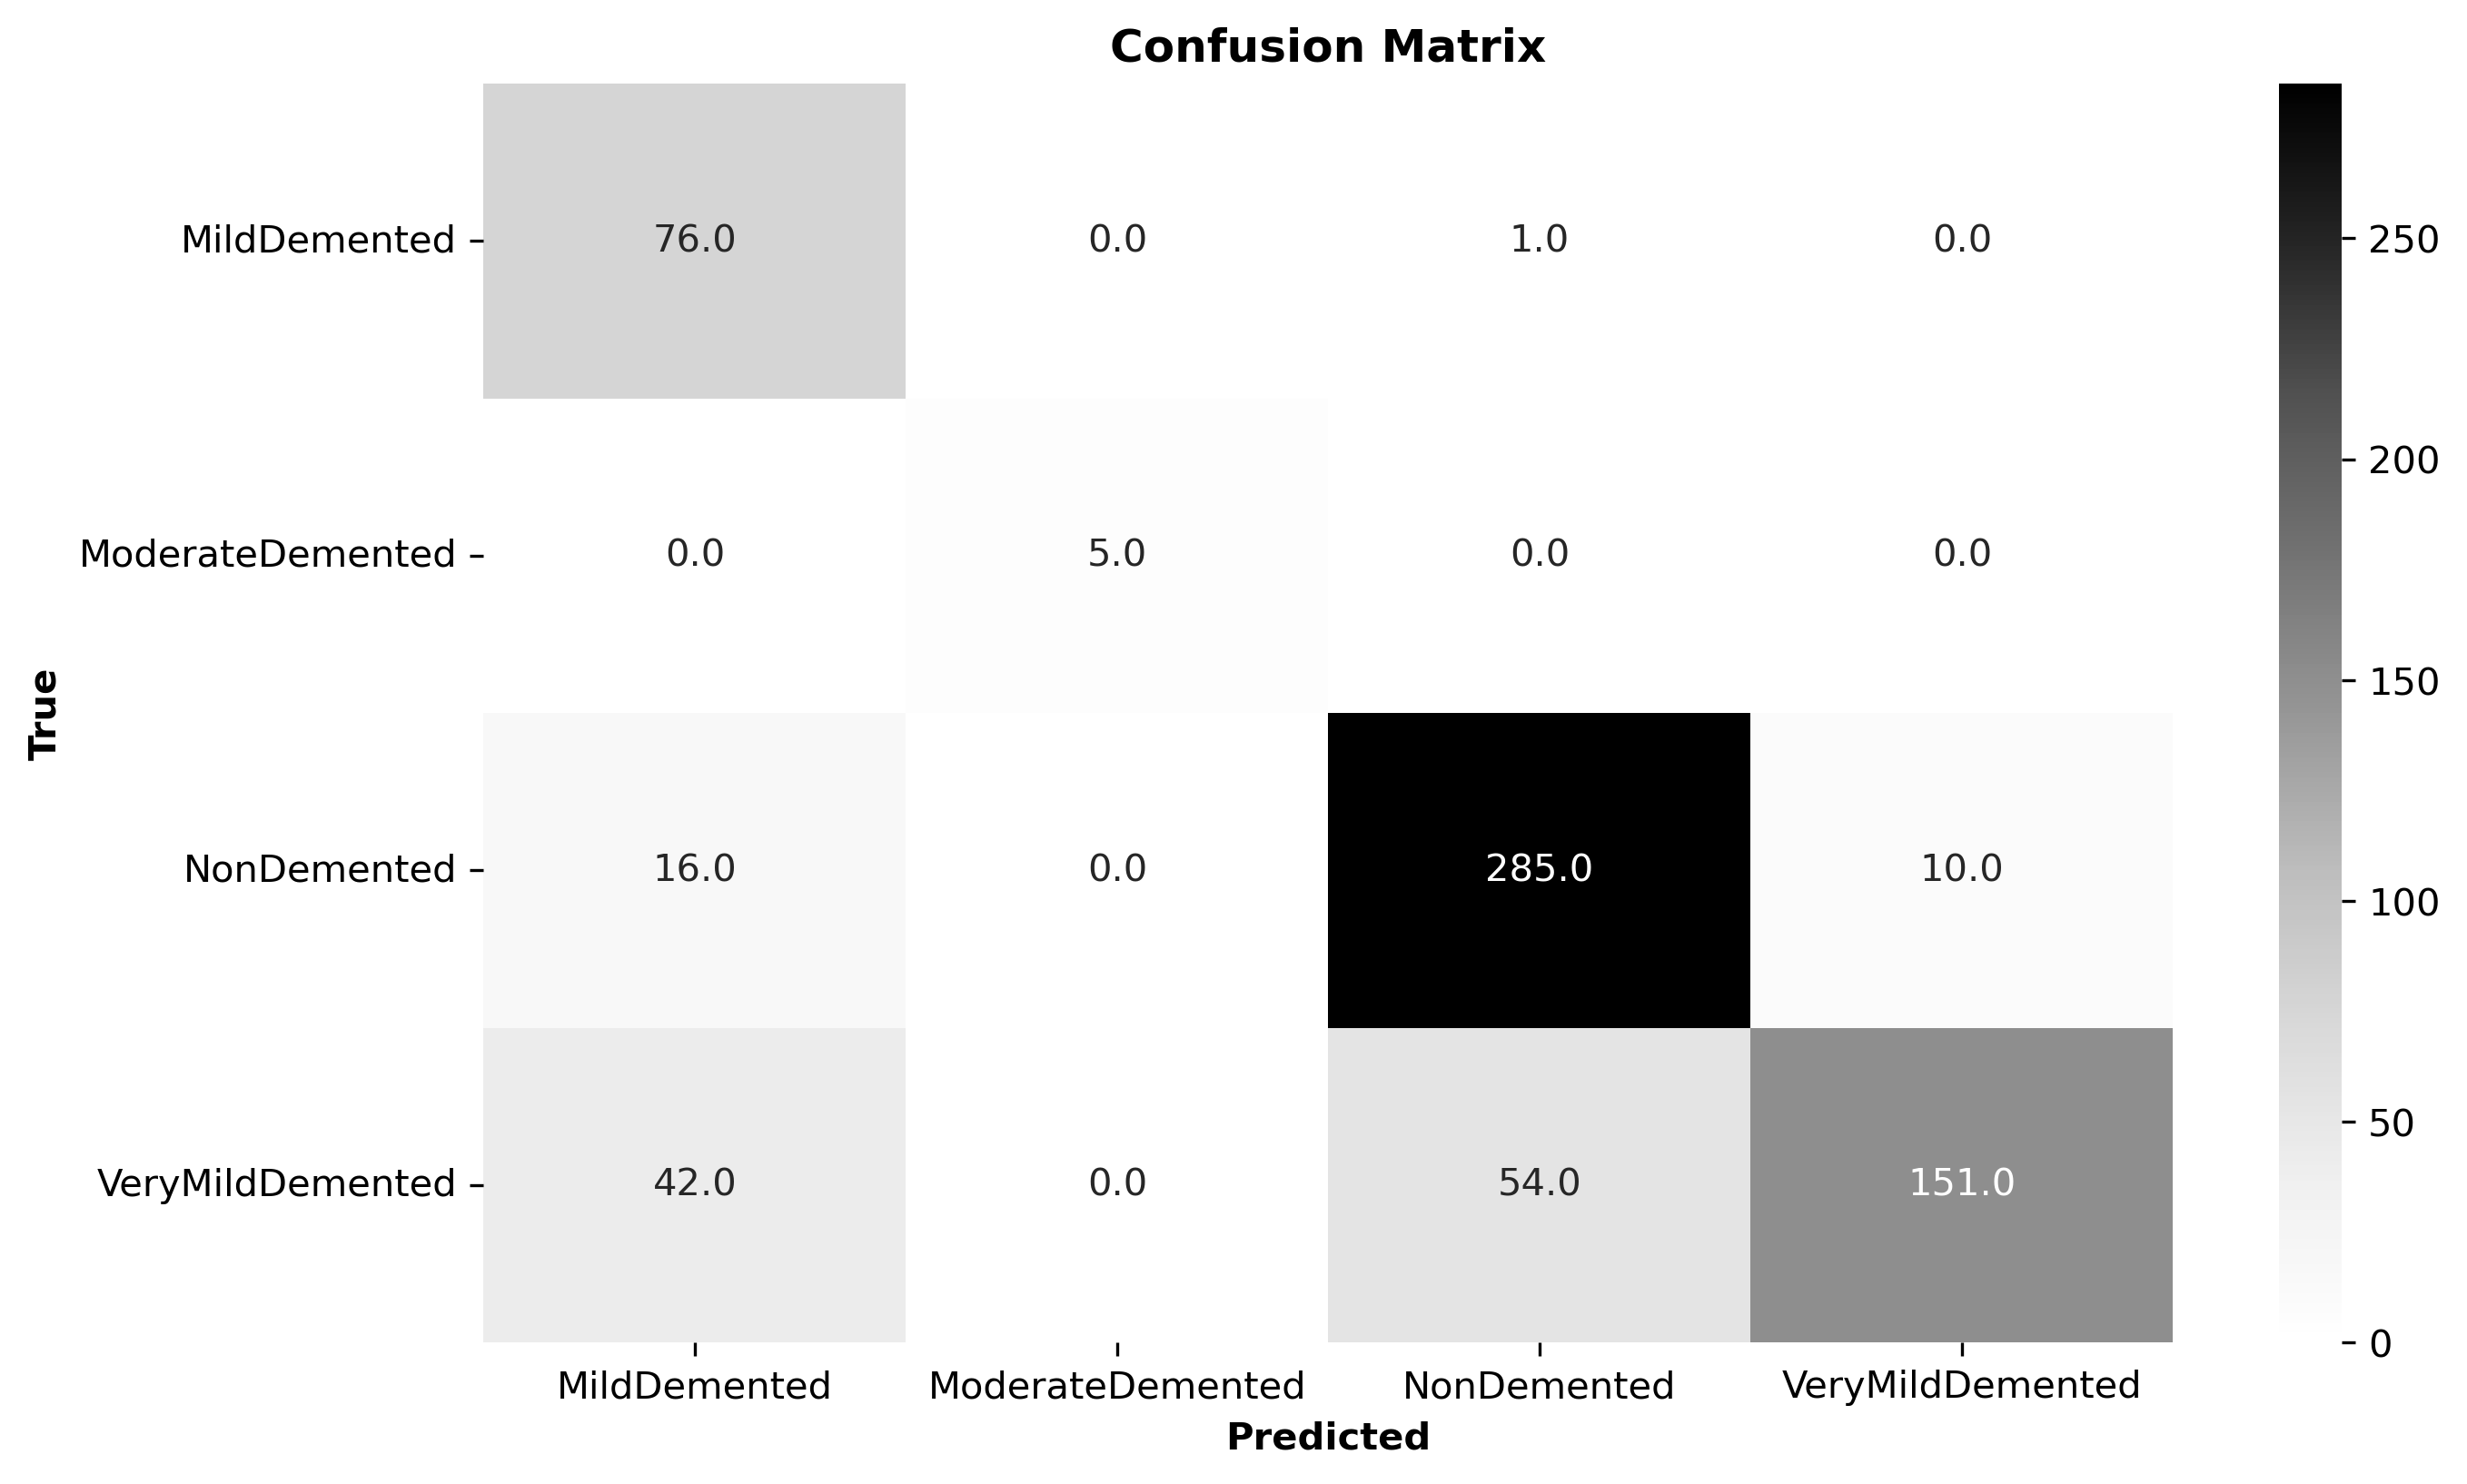

In [34]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">
Let's create a function that fetches a random image and displays a pie chart showing the probability distribution of which target value the image belongs to, represented as percentages. In this way, it will be seen which class the model gives the highest probability to.</p>

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Alzheimer Probability of a Random MRI from Test Data</h2>

1/1 [==============================] - 0s 90ms/step


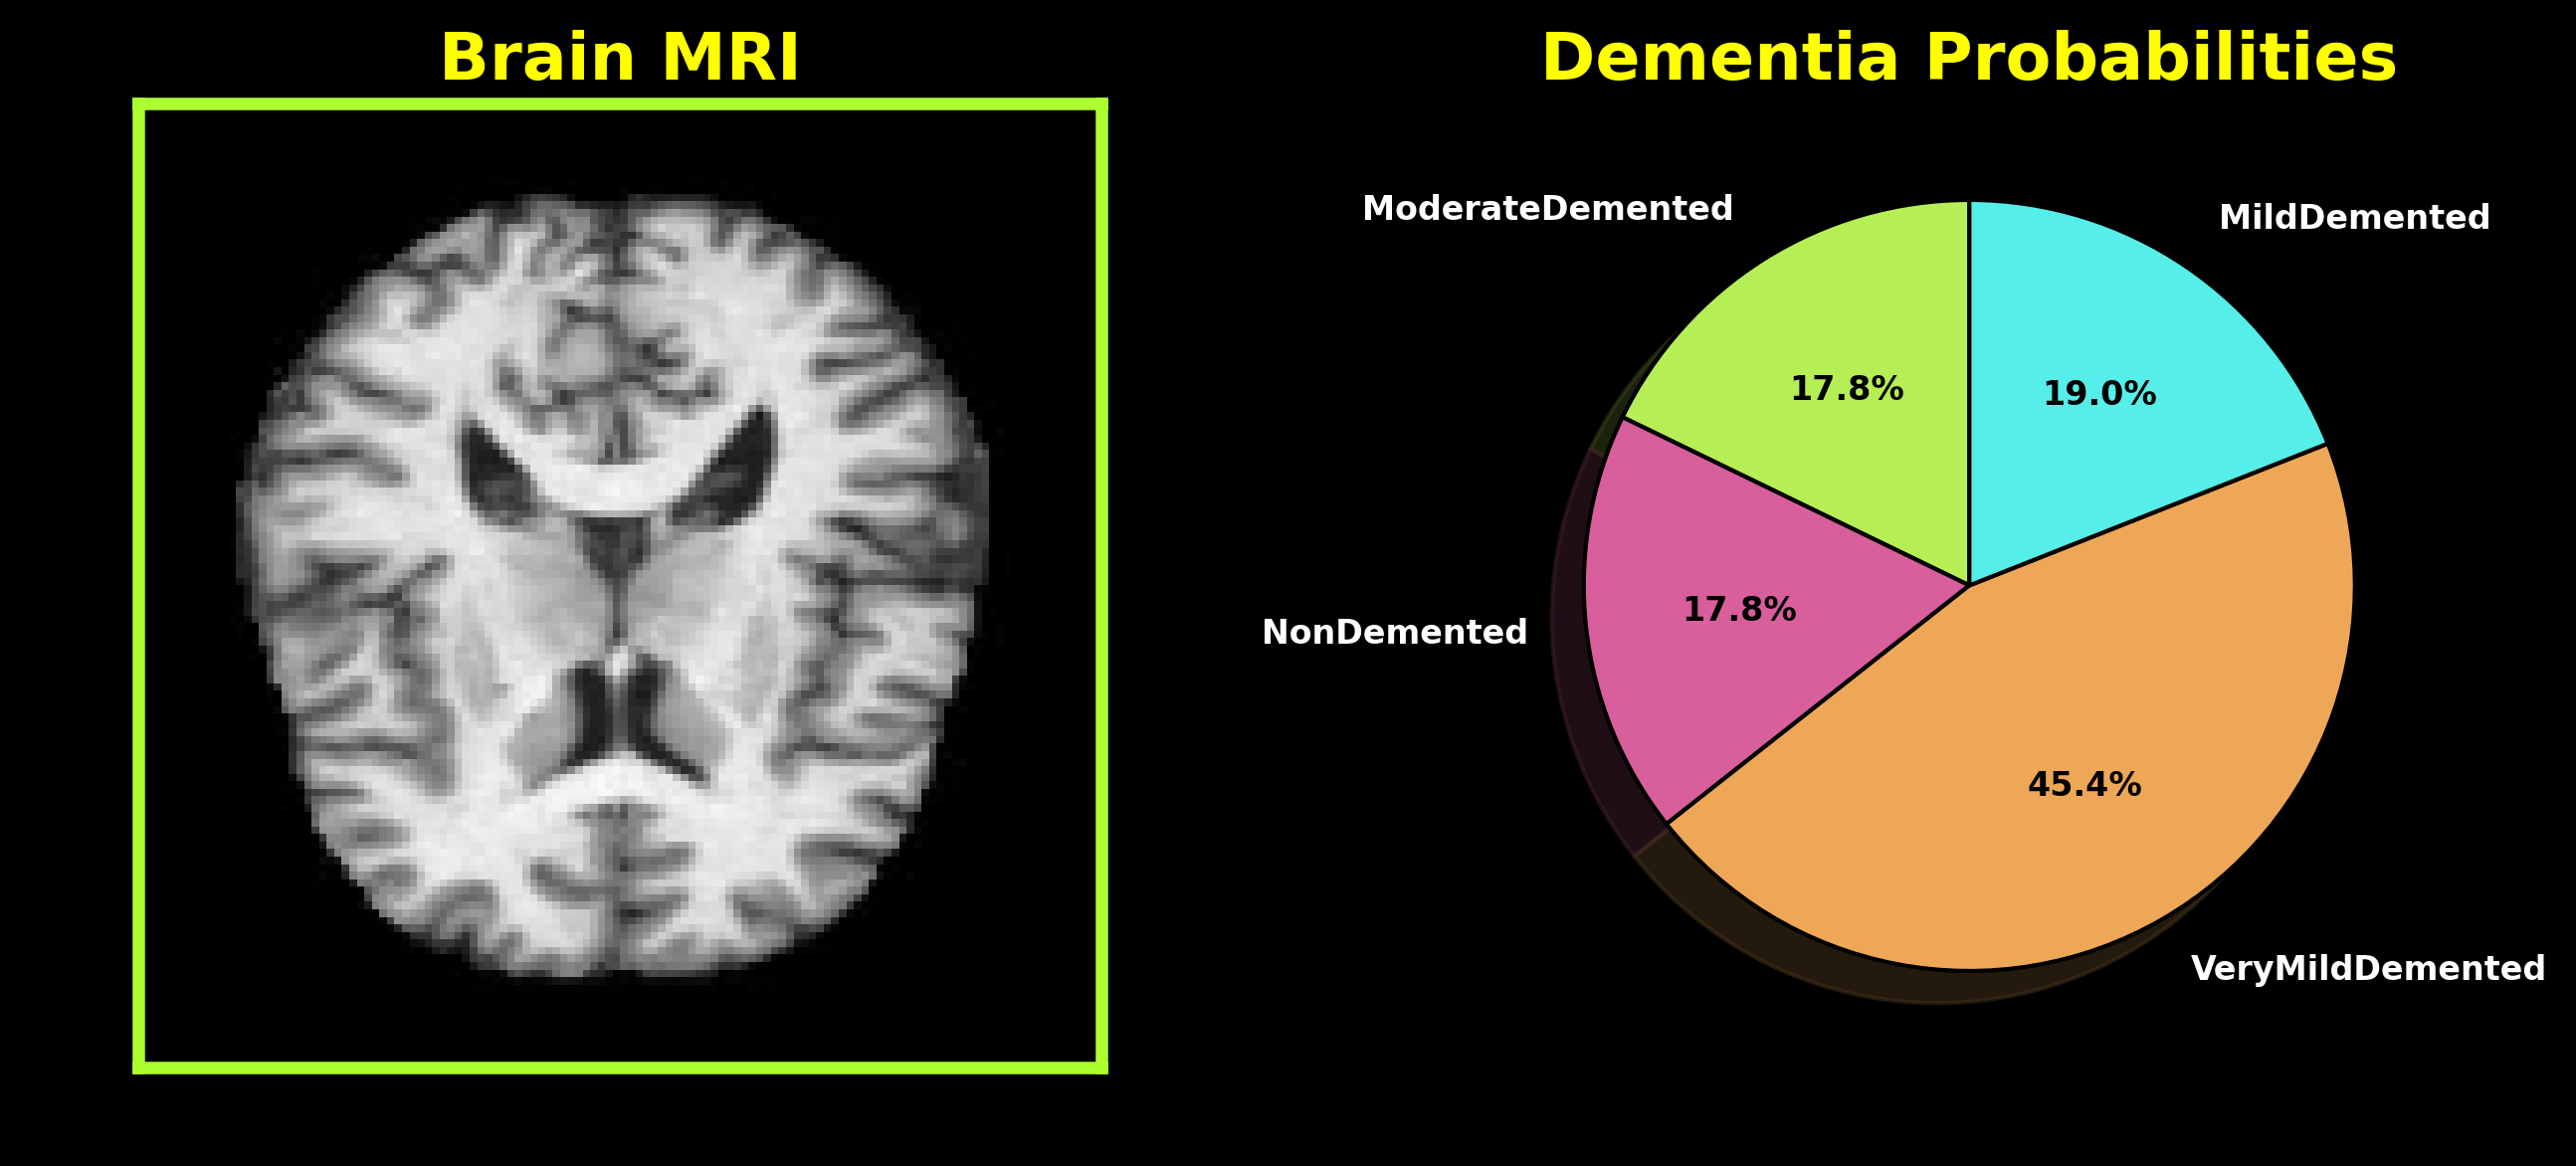

In [35]:
def random_mri_prob_bringer(image_number=0):
    
    for images, _ in test_data.skip(5).take(1):
        image = images[image_number]
        pred = model.predict(tf.expand_dims(image, 0))[0]
        
    probs = list(tf.nn.softmax(pred).numpy()) 
    probs_dict = dict(zip(class_dist.keys(), probs))
    
    keys = list(probs_dict.keys())
    values = list(probs_dict.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='black')
    plt.subplots_adjust(wspace=0.4) 
    ax1.imshow(image)
    ax1.set_title('Brain MRI', color="yellow", fontweight="bold", fontsize=16)
    
    edges = ['left', 'bottom', 'right', 'top']
    edge_color = "greenyellow"
    edge_width = 3
    for edge in edges:
        ax1.spines[edge].set_linewidth(edge_width)
        ax1.spines[edge].set_edgecolor(edge_color)

    plt.gca().axes.yaxis.set_ticklabels([])        
    plt.gca().axes.xaxis.set_ticklabels([])

    wedges, labels, autopct = ax2.pie(values, labels=keys,  autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 8, "fontweight":"bold", "color":"white"},  wedgeprops=
       {'edgecolor':'black'} , labeldistance=1.15)

    for autotext in autopct:
        autotext.set_color('black')

    ax2.set_title('Dementia Probabilities', color="yellow", fontweight="bold", fontsize=16)
    
rand_img_no = np.random.randint(1, 32)
random_mri_prob_bringer(image_number=rand_img_no)

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">
Now, let's see the actual classes and predicted classes of these samples by bringing samples from our test data.</p>

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Comparing Predicted Classes with the Actual Classes from the Test Data</h2>

ValueError: weight='bAold' is invalid

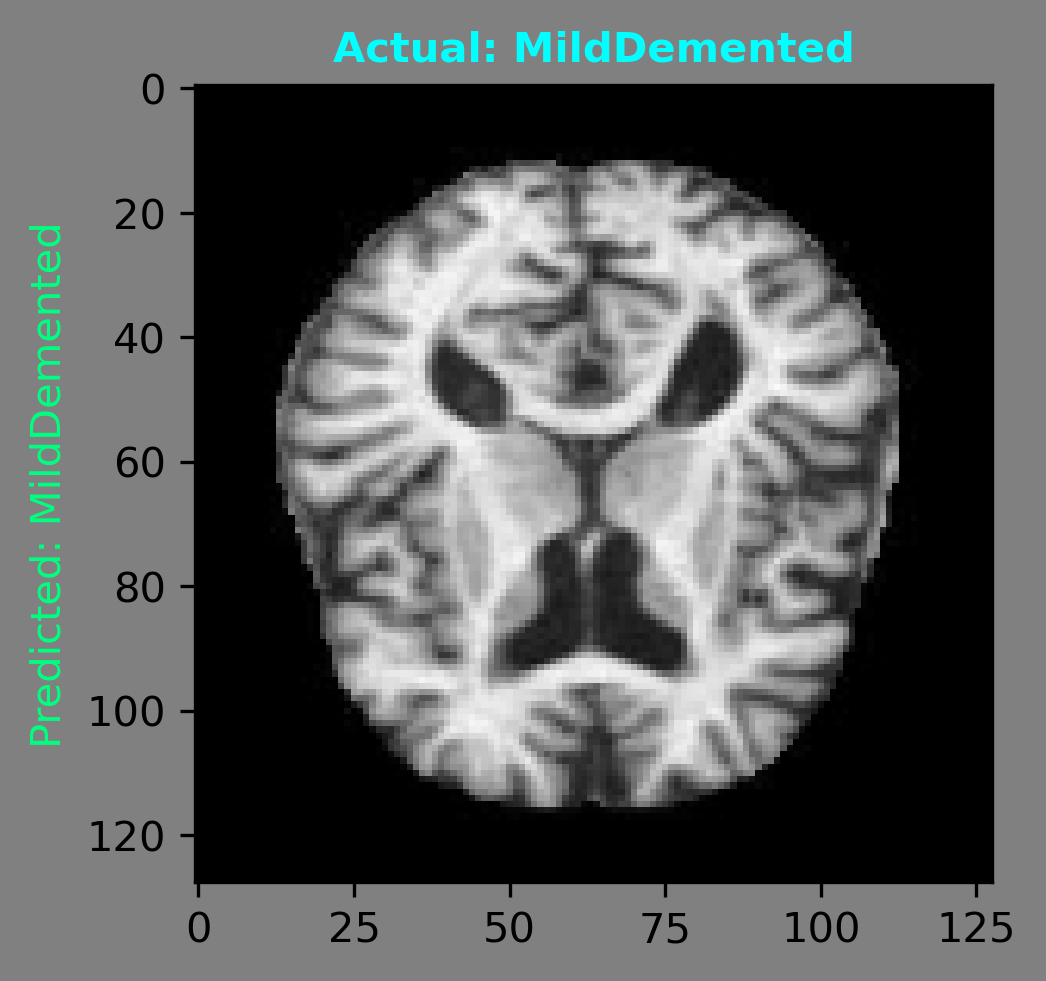

In [36]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bAold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))
    
        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

<h3 style="color:tomato">I hope you enjoyed it.<br><br>
Please upvote if you like this notebook. Any feedbacks are welcome. Thank you in advance!</h3>